In [1]:
using InteractiveUtils, DrWatson, Comonicon
if isdefined(Main, :IJulia) && Main.IJulia.inited
    using Revise
else
    ENV["GKSwstype"] = 100 # suppress warnings during gif saving
end
versioninfo()
@quickactivate

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
Environment:
  JULIA_NUM_THREADS = 10


In [2]:
using Plots, ProgressMeter, Logging
theme(:bright; size=(300, 300))

In [3]:
using Random, Turing, BayesianSymbolic
using ExprOptimization.ExprRules

includef(args...) = isdefined(Main, :Revise) ? includet(args...) : include(args...)
includef(srcdir("utility.jl"))
includef(srcdir("app_inf.jl"))
includef(srcdir("sym_reg.jl"))
includef(srcdir("exp_max.jl"))
includef(srcdir("analyse.jl"))
includef(srcdir("dataset.jl"))
# Suppress warnings of using _varinfo
with_logger(SimpleLogger(stderr, Logging.Error)) do
    includef(srcdir("scenarios", "ullman.jl"))
end

includef(scriptsdir("ullman_hacks.jl"))

┌ Info: Precompiling BayesianSymbolic [d95aa7d0-ea3e-4103-b443-9ed45b862455]
└ @ Base loading.jl:1317
┌ Info: Skipping precompilation since __precompile__(false). Importing BayesianSymbolic [d95aa7d0-ea3e-4103-b443-9ed45b862455].
└ @ Base loading.jl:1025
┌ Warning: skipping callee #_#38 (called by nothing) due to UndefRefError()
└ @ LoweredCodeUtils /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/LoweredCodeUtils/poBmh/src/signatures.jl:279


In [4]:
scenario, attribute = loadullman(datadir("ullman", "processed"), 1)

foreach(scenario.scenes) do scene
    @info scene.group
    @info groupinfo(scene.group)
end

@info attribute

@info compute_normrmse(
    UllmanScenario, [scenario], make_latents([attribute]), BayesianSymbolic.getforce, Likelihood(nahead=1)
)

┌ Info: [3, 5, 1, 1, 2, 4, 7, 7, 7, 7]
└ @ Main In[4]:4
┌ Info: (nmats = 2, ndiscs = 4, nwalls = 4, localidcs = [1, 2, 1, 1, 2, 3, -1, -1, -1, -1])
└ @ Main In[4]:5
┌ Info: [3, 5, 1, 1, 2, 2, 7, 7, 7, 7]
└ @ Main In[4]:4
┌ Info: (nmats = 2, ndiscs = 4, nwalls = 4, localidcs = [1, 2, 1, 1, 2, 2, -1, -1, -1, -1])
└ @ Main In[4]:5
┌ Info: [3, 5, 1, 1, 2, 4, 7, 7, 7, 7]
└ @ Main In[4]:4
┌ Info: (nmats = 2, ndiscs = 4, nwalls = 4, localidcs = [1, 2, 1, 1, 2, 3, -1, -1, -1, -1])
└ @ Main In[4]:5
┌ Info: [5, 6, 2, 2, 4, 4, 7, 7, 7, 7]
└ @ Main In[4]:4
┌ Info: (nmats = 2, ndiscs = 4, nwalls = 4, localidcs = [2, 3, 2, 2, 3, 3, -1, -1, -1, -1])
└ @ Main In[4]:5
┌ Info: [3, 5, 1, 1, 2, 4, 7, 7, 7, 7]
└ @ Main In[4]:4
┌ Info: (nmats = 2, ndiscs = 4, nwalls = 4, localidcs = [1, 2, 1, 1, 2, 3, -1, -1, -1, -1])
└ @ Main In[4]:5
┌ Info: [3, 5, 1, 2, 2, 4, 7, 7, 7, 7]
└ @ Main In[4]:4
┌ Info: (nmats = 2, ndiscs = 4, nwalls = 4, localidcs = [1, 2, 1, 2, 2, 3, -1, -1, -1, -1])
└ @ Main In[4]:5
┌ Info: [3

┌ Info: Saved animation to 
│   fn = /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/notebooks/tmp.gif
└ @ Plots /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/Plots/IjNHT/src/animation.jl:104


Plots.AnimatedGif("/afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/notebooks/tmp.gif")
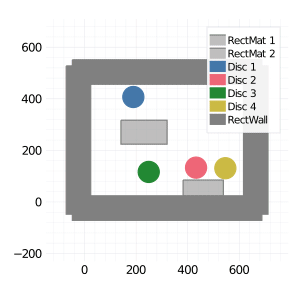

In [5]:
scene = scenario.scenes[2]

@gif for t in 1:length(scene.traj)
    plot(scene.entity, scene.traj, t)
end

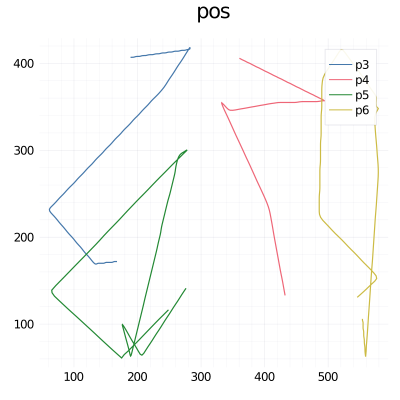

In [6]:
make_pos_plot(scene.traj)

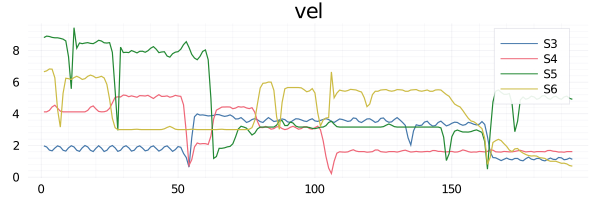

In [7]:
make_vel_plot(scene.traj)

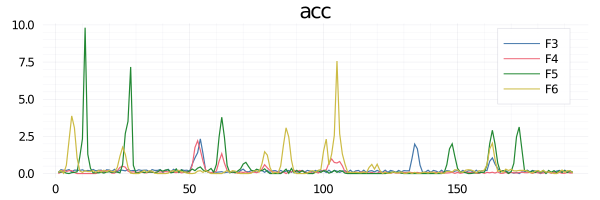

In [8]:
make_acc_plot(scene.traj)

In [9]:
d1 = Dict(i => i for i in 1:5)
d2 = Dict(i => i for i in 1:5)
d3 = Dict(0.01 => 1, 0.1 => 2, 1.0 => 3)
r3 = Dict(1 => 0.01, 2 => 0.1, 3 => 1.0)

results = []

Threads.@threads for (niterations, nahead, nlevel) in collect(Iterators.product(1:5, 1:5, [0.01, 0.1, 1.0]))

    force = let seed = 1,
        ScenarioModel = UllmanScenario,
        latentname = ["mass1", "mass2", "mass3", "charge1", "charge2", "charge3", "fric1", "fric2", "fric"],
        malg = HandCodedForce(niterations=niterations, mask=Bool[1,1,0,0,1]),
        mlike = Likelihood(nahead=nahead, nlevel=nlevel),
        scenarios = [scenario]
        attributes = [attribute]

        Random.seed!(seed)
        latents = make_latents(attributes) # orcale latents
        tused = @elapsed force = mstep(malg, ScenarioModel, scenarios, latents, mlike; verbose=true)

        force
    end

    push!(results, (force=force, niterations=niterations, nahead=nahead, nlevel))
    
end

┌ Info: Hand-coded force constants
│   C = 28.175918750044843
│   G₀ = 34.29226063107393
│   G = 0.0
│   Gm = 0.0
│   Gc = 0.0
└ @ Main /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/src/exp_max.jl:66
┌ Info: Hand-coded force constants
│   C = 28.25036456465042
│   G₀ = 0.08721602352323746
│   G = 0.0
│   Gm = 0.0
│   Gc = 0.0
└ @ Main /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/src/exp_max.jl:66
┌ Info: Hand-coded force constants
│   C = 9.623860133902811
│   G₀ = 0.01790364027165917
│   G = 0.0
│   Gm = 0.0
│   Gc = 0.0
└ @ Main /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/src/exp_max.jl:66
┌ Info: Hand-coded force constants
│   C = 20.030800778739415
│   G₀ = 0.047181231268803116
│   G = 0.0
│   Gm = 0.0
│   Gc = 0.0
└ @ Main /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/src/exp_max.jl:66
┌ Info: Hand-coded force constants
│   C = 28.175918750030778
│   G₀ = 34.29226063107392
│   G 

In [10]:
C = zeros(5, 5, 5, 3)
for res in results
    C[:,d1[res.niterations],d2[res.nahead],d3[res.nlevel]] = res.force.constant
end

┌ Info: nlevel=0.01
└ @ Main In[11]:2


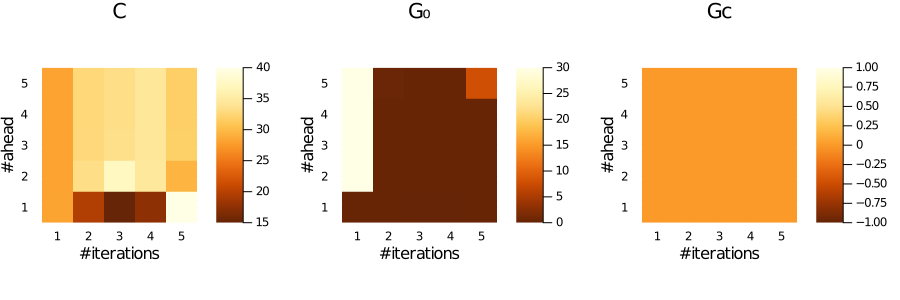

In [11]:
function vis_constants(C, inlevel)
    @info "nlevel=$(r3[inlevel])"

    constant_names = ["C", "G₀", "G", "Gm", "Gc"][[1,2,5]]
    clims = [(15, 40), (0, 30), (-1, 1)]
    ps = []

    xs = [string(i) for i in 1:5]
    ys = [string(i) for i in 1:5]

    for (i, (name, clim)) in enumerate(zip(constant_names, clims))
        z = C[i,:,:,inlevel]

        p = plot()
        heatmap!(p, xs, ys, z; aspect_ratio=1, clim=clim)
        xlabel!(p, "#iterations")
        ylabel!(p, "#ahead")
        title!(p, name)

        push!(ps, p)
    end

    plot(ps...; size=(300 * 3, 300), layout=Plots.GridLayout(1, length(constant_names)))
    
end

vis_constants(C, 1)

┌ Info: nlevel=0.1
└ @ Main In[11]:2


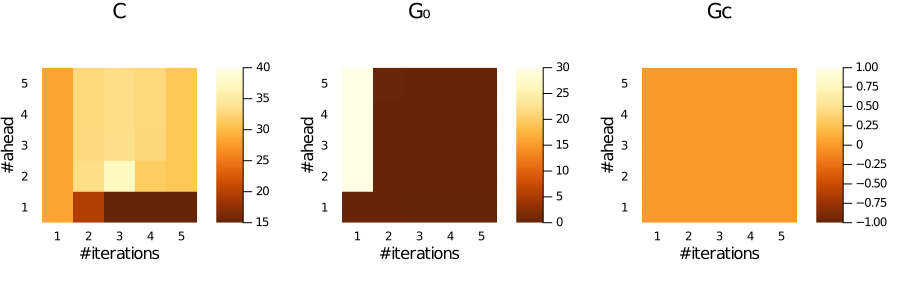

In [12]:
vis_constants(C, 2)

┌ Info: nlevel=1.0
└ @ Main In[11]:2


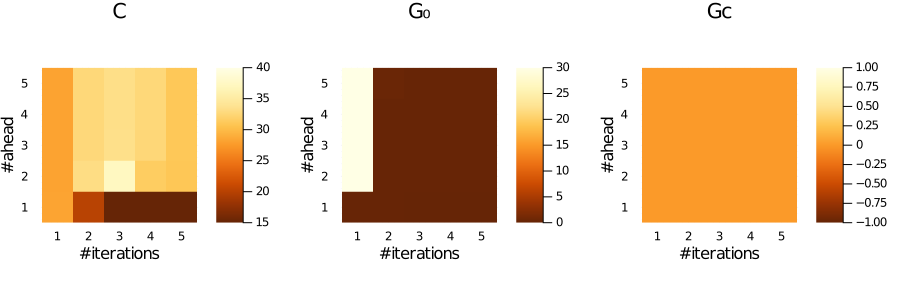

In [13]:
vis_constants(C, 3)

In [5]:
force_ext = let ScenarioModel = UllmanScenario, slient = false
    # Load World 1 for fitting external
    scenario_ext, attribute_ext = loadullman(datadir("ullman", "processed"), 1)

    malg_ext = HandCodedForce(niterations=3, mask=Bool[1,1,0,0,1])
    mlike_ext = Likelihood(nahead=3, nlevel=0.1)
    latents_ext = make_latents([attribute_ext])
    mstep(malg_ext, UllmanScenario, [scenario_ext], latents_ext, mlike_ext; verbose=!slient)
end

┌ Info: Hand-coded force constants
│   C = 33.40860623446217
│   G₀ = 0.0907080108791415
│   G = 0.0
│   Gm = 0.0
│   Gc = 0.0
└ @ Main /afs/inf.ed.ac.uk/user/s16/s1672897/projects/bayesian_symbolic_physics/src/exp_max.jl:66


HandCodedForce{Vector{Float64}, LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#17#19"}}([33.40860623446217, 0.0907080108791415, 0.0, 0.0, 0.0], Bool[1, 1, 0, 0, 1], LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#17#19"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#17#19"(), Optim.Flat(), true), 3)

In [38]:
function make_est(latent)
    _, i = findmax(map(l -> l.logweight, latent))
    return latent[i].value
end

results = []
forces = []
for wid in 1:10, sid in 1:6
    let niters = 3, seed = 0, slient = false
        try
            hps = @ntuple(wid, sid, niters, seed)

            scenario, attribute = loadullman(
                datadir("ullman", "processed"), wid; idcs=[sid]
            )
            scenarios = [scenario]

            res = wload(resultsdir("ullman", savename(hps; connector="-"), "em.jld2"))

            @unpack ScenarioModel, latentname, ealg, malg, elike, mlike, trace = res

            force = trace[end].force
            force = @set(force.external = external=make_getforce(force_ext))
            
            push!(forces, (wid=wid, expr=BayesianSymbolic.get_executable(force.tree, force.grammar)))

            latents = estep(ImportanceSampling(nsamples=500), ScenarioModel, scenarios, force, elike; verbose=!slient)

            est = expect.(x -> x, latents)[1]
#             est = make_est.(latents)[1]
            !slient && @info "" est attribute
            
            push!(results, (wid=wid, sid=sid, est=est, att=attribute))
        catch e
            if isa(e, InterruptException)
                throw(e)
            end
        end
    end
end

┌ Warning: read type var"#67#68"{Vector{Float64},HandCodedForce{Vector{Float64}, LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#17#19"}}} has a different number of parameters from type var"#67#68" in workspace; reconstructing
└ @ JLD2 /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/JLD2/qncOK/src/data/reconstructing_datatypes.jl:412
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16
┌ Info: 
│   est = [4.506477116549889, 9.000000000008685, 4.369175887191254, -0.04488402165034821, -0.09850494662308586, 0.03644406113261521, 6.570255379770628, 19.564243930001922, 7.043406725527072]
│   attribute = [3, 1, 9, 0, 0, 0, 20, 0, 5]
└ @ Main In[38]:31
┌ Warning: read type var"#67#68"{Vector{Float64},HandCodedForce{Vector{Float64}, LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#17#19"}}} has a different number of parameters from typ

1 incomplete frame(s) removed.


┌ Info: 
│   est = [5.21052631589561, 4.578947368514323, 3.000000000061109, 0.2631578947422026, -0.21052631579376208, 1.0000000000203697, 7.10526315803947, 20.000000000407397, 10.000000000203698]
│   attribute = [1, 9, 3, 0, 1, 1, 0, 5, 20]
└ @ Main In[38]:31
┌ Warning: read type var"#67#68"{Vector{Float64},HandCodedForce{Vector{Float64}, LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#17#19"}}} has a different number of parameters from type var"#67#68" in workspace; reconstructing
└ @ JLD2 /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/JLD2/qncOK/src/data/reconstructing_datatypes.jl:412
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:19
┌ Info: 
│   est = [3.7681741151086534, 4.778895643875022, 3.000000000331236, -0.0880128730231316, 0.022539295376647422, 0.07037486411884719, 9.794518418271378, 8.419185843420783, 0.10874824662603001]
│   attribute = [1, 9, 3, 0, 1, -1, 0, 5, 20]
└ @ Main In

1 incomplete frame(s) removed.


┌ Info: 
│   est = [5.380952177778735, 4.761904645602241, 2.999999999915308, -0.16666660539354475, 0.047619004234632965, 0.3333332269634992, 8.928572067607288, 8.333333321572638, 19.99999670857292]
│   attribute = [9, 3, 1, 1, 0, -1, 5, 20, 0]
└ @ Main In[38]:31
┌ Warning: read type var"#67#68"{Vector{Float64},HandCodedForce{Vector{Float64}, LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#17#19"}}} has a different number of parameters from type var"#67#68" in workspace; reconstructing
└ @ JLD2 /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/packages/JLD2/qncOK/src/data/reconstructing_datatypes.jl:412
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:29
┌ Info: 
│   est = [4.300001020475788, 3.300004945417795, 0.9999999999979976, 6.279904005155151e-7, 0.09999992150099966, -0.9999952900699933, 8.750010008579485, 7.749991953857473, 19.999999999959954]
│   attribute = [9, 3, 1, 1, 0, -1, 5, 20, 0]
└ @ Main 

In [40]:
function findclosest(s, x)
    l1 = Inf
    local retval
    for y in s
        _l1 = abs(y - x)
        if _l1 < l1
            l1 = _l1
            retval = y
        end
    end
    return retval
end

function answer_ques(est, att, opt)
    @assert length(est) == length(att)
    retval = []
    for i in 1:length(est)
        c = findclosest(opt, est[i])
        push!(retval, c == att[i])
    end
    return retval
end

cmass = []
cfric = []
for (wid, sid, est, att) in results
    append!(cmass, answer_ques(est[1:3], att[1:3], [1, 3, 9]))
    append!(cfric, answer_ques(est[7:9], att[7:9], [0, 5, 20]))
end
cmass |> mean, cfric |> mean

LoadError: UndefVarError: retval not defined

In [34]:
function make_mat(est, att, opt)
    @assert length(est) == length(att)
    mat = zeros(3, 3)
    for i in 1:length(est)
        attidx = findfirst(sort(att) .== att[i])
        c = findclosest(opt, est[i])
        cidx = findfirst(sort(att) .== c)
        mat[attidx,cidx] += 1
    end
    return mat
end

mmass = []
mfric = []
for (wid, sid, est, att) in results
    push!(mmass, make_mat(est[1:3], att[1:3], [1, 3, 9]))
    push!(mfric, make_mat(est[7:9], att[7:9], [0, 5, 20]))
end

mmass |> mean

3×3 Matrix{Float64}:
 0.363636  0.5       0.136364
 0.272727  0.545455  0.181818
 0.431818  0.295455  0.272727

In [35]:
mfric |> mean

3×3 Matrix{Float64}:
 0.272727  0.272727  0.454545
 0.340909  0.204545  0.454545
 0.272727  0.272727  0.454545

In [123]:
filter(f -> f.wid == 10, forces)

4-element Vector{Any}:
 (wid = 10, expr = :(c2 * bmul(bmul(bpow2(bproject(bsub(vi, vj), bdiv(bsub(pi, pj), bnorm(bsub(pi, pj))))), bnorm(bsub(vi, vj))), bdiv(bsub(pi, pj), bnorm(bsub(pi, pj))))))
 (wid = 10, expr = :(badd(badd(c3 * bmul(bdiv(bpow2(bproject(vj, bdiv(bsub(pi, pj), bnorm(bsub(pi, pj))))), bnorm(bsub(pi, pj))), bdiv(bsub(pi, pj), bproject(bsub(pi, pj), bnormalize(vj)))), c2 * bmul(bdiv(bsub(qi, qj), bpow2(bnorm(bsub(vi, vj)))), bdiv(bsub(vi, vj), bnorm(vj)))), c3 * bmul(bdiv(bpow2(bproject(bsub(pi, pj), bdiv(vj, bnorm(bsub(vi, vj))))), bpow2(bnorm(bsub(pi, pj)))), bdiv(bsub(vi, vj), bproject(bsub(vi, vj), bdiv(bsub(pi, pj), bproject(bsub(pi, pj), bdiv(bsub(vi, vj), bproject(vj, bdiv(bsub(pi, pj), bnorm(bsub(pi, pj)))))))))))))
 (wid = 10, expr = :(badd(c1 * bmul(bdiv(bnorm(bsub(pi, pj)), bpow2(qj)), bdiv(bsub(pi, pj), bnorm(bsub(pi, pj)))), c1 * bmul(bdiv(bmul(qi, qj), qj), bdiv(bsub(vi, vj), bproject(vj, bdiv(bsub(pi, pj), bnorm(bsub(pi, pj)))))))))
 (wid = 10, expr = :(c

In [133]:
cgforce = [
    true, false, true, true, false, true,
    true, true, false, true, false, true,
    false, true, true, false, false,
    true, false,
    true, true,
    true, true, true, true,
    
    true, false, true, true, false,
    
    false, false, false, false, false, false,
    
    true, true, true, true,
    
    false, false, false, false,
] 

cgforce |> mean

0.5454545454545454

In [134]:
cpforce = [
    true, true, true, true, true, true,
    false, false, false, true, false, true,
    true, false, true, true, false,
    true, true,
    false, true,
    false, true, false, false,
    false, false, true, true, false,
    true, true, true, false, true, false,
    false, false, false, false,
    false, false, true, false
] 

cpforce |> mean

0.5